In [1]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

In [2]:
def single_bound_diffusion(v,a,dt=1e-4,dB=1e-2):
    DV = 0; t = 0
    while True:
        DV += v*dt + np.random.normal(0, dB)
        t += dt

        if DV >= a:
            return t

In [3]:
dt = 1e-4
dB = np.sqrt(dt)
v = 1
a = 2
N_sim = int(50e3)

In [4]:
sim_results = Parallel(n_jobs=-1)(delayed(single_bound_diffusion)(v,a,dt,dB) for _ in range(N_sim))

In [5]:
def rho_A_t_fn(t, V_A, theta_A):
    """
    For AI,prob density of t given V_A, theta_A
    """
    if t <= 0:
        return 0
    return (theta_A*1/np.sqrt(2*np.pi*(t)**3))*np.exp(-0.5 * (V_A**2) * (((t) - (theta_A/V_A))**2)/(t))


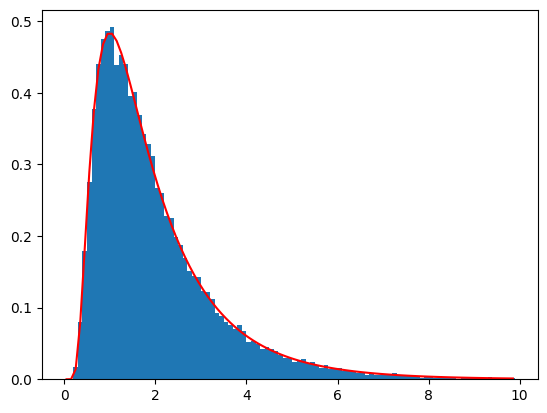

In [6]:
bin_width = 0.1
bins = np.arange(0, 10, bin_width)
plt.hist(sim_results, bins=bins, density=True);

t_pts = bins[:-1] + bin_width/2
pdf = [rho_A_t_fn(t, v, a) for t in t_pts]
plt.plot(t_pts, pdf, 'r-')

# SNLE

## proposal and prior

### NOT being used

In [7]:
# priors and proposal
from torch.distributions import Uniform
from sbi.utils import MultipleIndependent
import torch

# Define the distributions for "v" and "a"
v_Distribution = Uniform(torch.tensor([0.1]), torch.tensor([5.0]))
a_Distribution = Uniform(torch.tensor([0.1]), torch.tensor([5.0]))

# Group the distributions into a prior
prior = MultipleIndependent(
    [
        v_Distribution,  # Uniform distribution for "v"
        a_Distribution,  # Uniform distribution for "a"
    ],
    validate_args=False,
)

# Group the distributions into a proposal (if needed)
proposal = MultipleIndependent(
    [
        v_Distribution,  # Uniform distribution for "v"
        a_Distribution,  # Uniform distribution for "a"
    ],
    validate_args=False,
)

## simulator

In [58]:
import torch
import numpy as np

def simulate_single_bound_diffusion(params):
    """
    Simulates single-bound diffusion for a batch of parameters.

    Args:
        params: Tensor of shape (batch_size, 2)
                - params[:, 0]: v (drift rate)
                - params[:, 1]: a (threshold)

    Returns:
        Tensor of shape (batch_size, 1) containing decision times for each parameter set.
    """
    v, a = params[:, 0], params[:, 1]  # Extract v and a
    batch_size = params.shape[0]
    dt = 1e-4
    dB = np.sqrt(dt)

    decision_times = []
    for i in range(batch_size):
        DV = 0.0  # Initialize decision variable
        t = 0.0   # Initialize time
        while True:
            DV += v[i] * dt + np.random.normal(0, dB)  # Update decision variable
            t += dt  # Increment time
            if DV >= a[i]:  # Check if threshold is crossed
                decision_times.append(t)
                break

    # Convert decision times to a tensor of shape (batch_size, 1)
    # return torch.tensor(decision_times).reshape(-1, 1)
    return np.array(decision_times)

## In parallel?

In [9]:
import torch

def simulate_single_bound_diffusion_parallel(params):
    """
    Simulates single-bound diffusion for a batch of parameters in parallel.

    Args:
        params: Tensor of shape (batch_size, 2)
                - params[:, 0]: v (drift rate)
                - params[:, 1]: a (threshold)

    Returns:
        Tensor of shape (batch_size, 1) containing decision times for each parameter set.
    """
    params = params.cpu().numpy()  # Convert to NumPy for compatibility with Joblib
    results = Parallel(n_jobs=-1)(
        delayed(single_bound_diffusion)(v, a) for v, a in params
    )
    return torch.tensor(results).reshape(-1, 1)


test simulator

In [10]:
params = torch.tensor([[0.5, 1.0], [0.3, 1.5], [0.7, 0.8]])  # Example batch of parameters
decision_times = simulate_single_bound_diffusion_parallel(params)
print(decision_times)


tensor([[1.3474],
        [4.2064],
        [0.1286]])


## test simulator by giving same param set

In [11]:
params = torch.tensor([v,a])
N_sim = int(50e3)
repeated_params = params.repeat(N_sim, 1)
print(repeated_params.shape)

rts = simulate_single_bound_diffusion_parallel(repeated_params)

torch.Size([50000, 2])


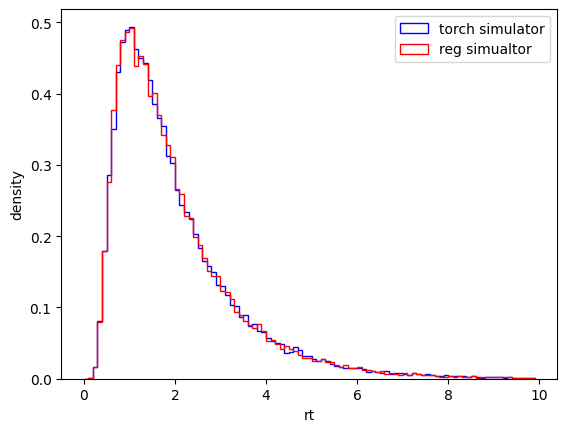

In [12]:
# convert rts = numpy array
rts_np = rts.numpy()

plt.hist(rts_np, bins=bins, density=True, histtype='step', color='blue', label='torch simulator');
plt.hist(sim_results, bins=bins, density=True, label='reg simualtor', color='r', histtype='step');
plt.xlabel('rt')
plt.ylabel('density')
plt.legend()

## trainer MNLE

In [53]:
N_sim = int(50e3)

In [54]:
theta = proposal.sample((N_sim,))

In [ ]:
x = simulate_single_bound_diffusion_parallel(theta)

In [55]:
from sbi.inference import simulate_for_sbi

In [59]:
theta, x = simulate_for_sbi(
        simulator=simulate_single_bound_diffusion,
        proposal=prior,
        num_simulations=N_sim,
        num_workers=31,
        # simulation_batch_size=int(100)
    )

  0%|          | 0/50000 [00:00<?, ?it/s]

TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

In [ ]:
theta.shape, x.shape

(torch.Size([500000, 2]), torch.Size([500000, 1]))

In [ ]:
from sbi.inference import SNLE
from sbi.utils.get_nn_models import posterior_nn

# Define the neural network
# custom_network = posterior_nn(model="maf", hidden_features=128, num_transforms=5)

trainer = SNLE()
estimator = trainer.append_simulations(theta, x).train(training_batch_size=512, num_epochs=100)


IndexError: The shape of the mask [500000] at index 0 does not match the shape of the indexed tensor [99, 2] at index 0

In [29]:
trainer._neural_net

NFlowsFlow(
  (net): Flow(
    (_transform): CompositeTransform(
      (_transforms): ModuleList(
        (0): PointwiseAffineTransform()
        (1): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=1, out_features=50, bias=True)
            (context_layer): Linear(in_features=2, out_features=50, bias=True)
            (blocks): ModuleList(
              (0-1): 2 x MaskedFeedforwardBlock(
                (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (final_layer): MaskedLinear(in_features=50, out_features=2, bias=True)
          )
        )
        (2): RandomPermutation()
        (3): MaskedAffineAutoregressiveTransform(
          (autoregressive_net): MADE(
            (initial_layer): MaskedLinear(in_features=1, out_features=50, bias=True)
            (context_layer): Linear(in_feature

# likelihood

In [18]:
v = 1; a = 2
sim_results = Parallel(n_jobs=-1)(delayed(single_bound_diffusion)(v,a) for _ in range(int(50e3)))

In [19]:
bin_width = 0.1
bins = np.arange(0, 10, bin_width)
t_pts = bins[:-1] + bin_width/2

In [ ]:
Dv, a = 1.0, 2.0  # rift rate and threshold
theta = torch.tensor([[v, a]] * len(t_pts))  # Repeat (v, a) for all t_pts

In [21]:
# Observations (t_pts as reaction times)
t_pts_tensor = torch.tensor(t_pts).reshape(-1, 1)  # Reshape to (n_samples, 1)

In [22]:
t_pts_tensor.shape, theta.shape

(torch.Size([99, 1]), torch.Size([99, 2]))

In [23]:
t_pts_tensor_reshaped = t_pts_tensor.unsqueeze(0)  
t_pts_tensor_reshaped.shape

torch.Size([1, 99, 1])

In [24]:
t_pts_tensor_reshaped = t_pts_tensor_reshaped.to(dtype=torch.float32)
theta = theta.to(dtype=torch.float32)

In [25]:
log_likelihood = estimator.log_prob(t_pts_tensor_reshaped, theta)


In [26]:
likelihood = torch.exp(log_likelihood)

In [27]:
# convert likelihood to numpy array
likelihood = likelihood.detach().numpy()

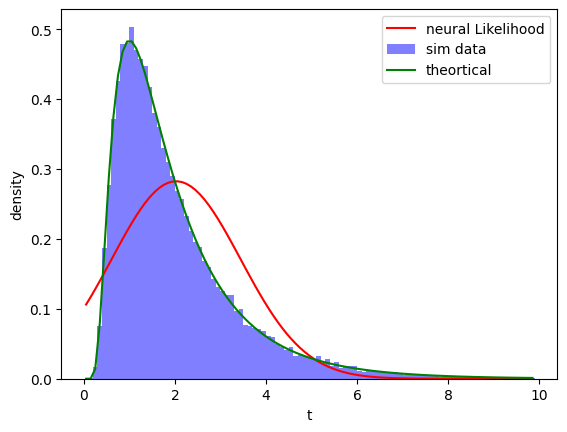

In [28]:
plt.plot(t_pts, likelihood.squeeze(), label="neural Likelihood", color='r')
plt.hist(sim_results, bins=bins, density=True, alpha=0.5, label="sim data", color='b')
plt.plot(t_pts, [rho_A_t_fn(t, v, a) for t in t_pts], label="theortical", color='g')

plt.xlabel('t')
plt.ylabel('density')
plt.legend()


In [33]:
trainer._summary

{'epochs_trained': [72],
 'best_validation_loss': [0.7274410070217762],
 'validation_loss': [0.7761360726405665,
  0.7533242806945879,
  0.7393408983024126,
  0.7425643629634503,
  0.7448998032156954,
  0.7617555739953346,
  0.735129275272802,
  0.7433102745370767,
  0.7334162967721212,
  0.7436344174994636,
  0.7354754676523897,
  0.7532760107640138,
  0.7316327156479826,
  0.7304842472076416,
  0.7476137219016085,
  0.7345226800318846,
  0.7332993487721866,
  0.7558182023235203,
  0.7335032064890125,
  0.7421500593731084,
  0.7492361965867662,
  0.7289107527929483,
  0.7311626740337647,
  0.7314797510805818,
  0.744545311042943,
  0.729760906745478,
  0.7292218245181841,
  0.7391897968410217,
  0.733140635121729,
  0.7310272627270099,
  0.7309029679937461,
  0.7356892602959859,
  0.7346527871397353,
  0.7314919337783892,
  0.7424832865134957,
  0.7368730368073454,
  0.7365048834958028,
  0.7336477090402976,
  0.733242251209377,
  0.7371495307720813,
  0.7318122085836745,
  0.72811425

In [60]:
trainer._summary

{'epochs_trained': [],
 'best_validation_loss': [],
 'validation_loss': [],
 'training_loss': [],
 'epoch_durations_sec': []}

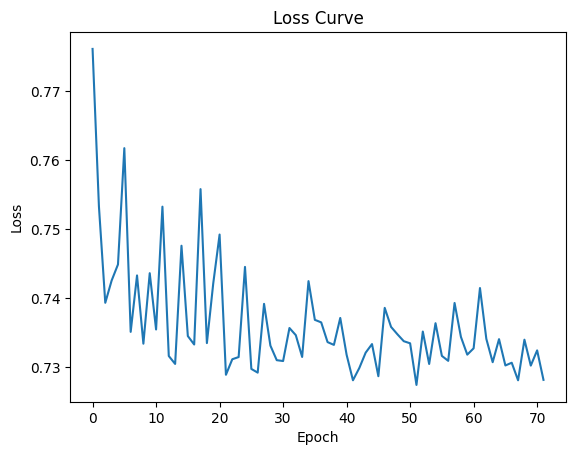

In [34]:

# Access the loss curve
loss_history = trainer._summary["validation_loss"]

# Plot the loss curve (optional)
import matplotlib.pyplot as plt

plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.show()
